In [1]:
from sympy import *
import mpmath
import numpy as np
import matplotlib.pyplot as plt
s = symbols('s')


In [2]:
# Define the xi function (complete zeta function)
Z = pi**(-s/2)*gamma(s/2)*zeta(s)
# We can verify that Z is indeed real for s = 1/2 + it
Z.subs(s, 1/2 + 0.5j).evalf()

 




-1.97702795164031 + 5.49690501450151e-17*I

In [14]:
# We get a small imaginary part due to the way floating point arithmetic works. Since it is below 1e-15, we can safely ignore it.

# D will be the logarithmic derivative of Z.
D = simplify(Z.diff(s)/Z)
D
polygamma(0, s/2)/2 - log(pi)/2 + Derivative(zeta(s), s)/zeta(s)

polygamma(0, s/2)/2 - log(pi)/2 + Derivative(zeta(s), s)/zeta(s)

In [15]:
# We now use lambdify to convert the SymPy expressions Z and D into functions that are evaluated using mpmath. A technical difficulty here is that the derivative of the zeta function 
#  does not have a closed-form expression. mpmath's zeta can evaluate 
#  but it doesn't yet work with sympy.lambdify (see SymPy issue 11802). So we have to manually define "Derivative" in lambdify, knowing that it will be the derivative of zeta when it is called. Beware that this is only correct for this specific expression where we know that Derivative will be Derivative(zeta(s), s).We now use lambdify to convert the SymPy expressions Z and D into functions that are evaluated using mpmath. A technical difficulty here is that the derivative of the zeta function 
#  does not have a closed-form expression. mpmath's zeta can evaluate 
#  but it doesn't yet work with sympy.lambdify (see SymPy issue 11802). So we have to manually define "Derivative" in lambdify, knowing that it will be the derivative of zeta when it is called. Beware that this is only correct for this specific expression where we know that Derivative will be Derivative(zeta(s), s).
Z_func = lambdify(s, Z, 'mpmath')
D_func = lambdify(s, D, modules=['mpmath',{'Derivative': lambda expr, z: mpmath.zeta(z, derivative=1)}])


In [10]:
def argument_count(func, N, maxdegree=6):
    return 1/(2*mpmath.pi*1j)*(mpmath.quad(func,[1 + 0.1j, 1 + N*1j, 0 + N*1j, 0 + 0.1j,  1 + 0.1j],maxdegree=maxdegree))
    

In [11]:
expr = s**2 - s + S(1)/2
argument_count(lambdify(s, expr.diff(s)/expr), 10)

mpc(real='1.0', imag='3.4287545414000525e-24')

In [ ]:
# The integral is 1. We can confirm there is indeed one zero in this box, at 1/2 + i/2
solve(s**2 - s + S(1)/2)

In [9]:
# Now compute points of  along the critical line so we can count the sign changes. We also make provisions in case we have to increase the precision of mpmath to get correct results here. dps is the number of digits of precision the values are computed to. The default is 15, but mpmath can compute values to any number of digits. mpmath.chop zeros out values that are close to 0, which removes any numerically insignificant imaginary parts that arise from the floating point evaluation.

def compute_points(Z_func, N, npoints=10000, dps=15):
        import warnings
        old_dps = mpmath.mp.dps
        points = np.linspace(0, N, npoints)
        try:
            mpmath.mp.dps = dps
            L = [mpmath.chop(Z_func(i)) for i in 1/2 + points*1j]
        finally:
            mpmath.mp.dps = old_dps
        if L[-1] == 0:
            # mpmath will give 0 if the precision is not high enough, since Z
            # decays rapidly on the critical line.
            warnings.warn("You may need to increase the precision")
        return L

In [ ]:
# Next define a function to count the number of sign changes in a list of real values.
def sign_changes(L):
        """
        Count the number of sign changes in L
   
        Values of L should all be real.
        """
        changes = 0
        assert im(L[0]) == 0, L[0]
        s = sign(L[0])
        for i in L[1:]:
            assert im(i) == 0, i
            s_ = sign(i)
            if s_ == 0:
                # Assume these got chopped to 0
                continue
            if s_ != s:
                changes += 1
            s = s_
        return changes

In [6]:
# For example, for  from -10 to 10, there are 7 zeros ().
sign_changes(lambdify(s, sin(s))(np.linspace(-10, 10)))

7

In [16]:
# Now we can check how many zeros of  (and hence non-trivial zeros of ) we can find. According to Wikipedia, the first few non-trivial zeros of  in the upper half-plane are 14.135, 21.022, and 25.011.

# First try up to N = 2 .
argument_count(D_func, 20)

mpc(real='0.99999931531867581', imag='-3.2332902529067346e-24')

In [17]:
# Mathematically, the above value must be an integer, so we know it is 1.
#Now check the number of sign changes of Z(s) from 1/2 + 0i to 1/2 + 20i
L = compute_points(Z_func, 20)
sign_changes(L)

1

In [18]:
# So it checks out. There is one zero between 0 and 20i on the critical strip, and it is in fact on the critical line, as expected!

# Now let's verify the other two zeros from Wikipedia.
argument_count(D_func, 25)
L = compute_points(Z_func, 25)
sign_changes(L)
argument_count(D_func, 30)
L = compute_points(Z_func, 30)
sign_changes(L)

3

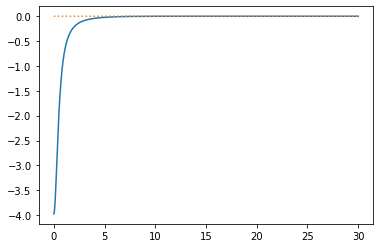

In [19]:
# Since we are computing the points, we can go ahead and make a plot as well. However, there is a technical difficulty. If you naively try to plot Z(1/2+it) , you will find that it decays rapidly, so fast that you cannot really tell where it crosses 0:
def plot_points_bad(L, N):
        npoints = len(L)
        points = np.linspace(0, N, npoints)
        plt.figure()
        plt.plot(points, L)
        plt.plot(points, [0]*npoints, linestyle=':')
plot_points_bad(L, 30)

In [ ]:
# So instead of plotting , we plot . The logarithm will make the zeros go to , but these will be easy to see.